In [79]:
import numpy as np
import time # Used to stop the time for Exercise 1

# Aufgabe 1

Implementieren Sie in python die Lösung eines linearen Gleichungssystems mit zyklischen Töplitz-
Matrizen mithilfe FFT (s. Skript S. 76). Verwenden Sie vorgefertigte Routinen z.B. numpy.fft.fft
und numpy.fft.ifft für die schnelle Fourier-Transformation sowie deren Inverse (Achtung, hier
wird evtl. bei der Berechnung der DFT nicht durch N dividiert, d.h. die Multiplikation mit N bei der
Berechnung von x entfällt). Lösen Sie außerdem das lineare Gleichungssystem Ax = b mit python,
z.B. mit numpy.linalg.solve.


Stoppen Sie für beide Varianten die benötigte Zeit für verschiedene
Werte von N und vergleichen Sie. Verwenden Sie zum Testen beispielsweise die Töplitz-Matrix,
welche durch $(a_j)^N_{j=0}$ mit $a_j = \frac{1}{j+1}$ erzeugt wird sowie die rechte Seiten Vektor $(b_j)^{N}_{J=0}$ mit $b_j = j^2$


Beginnen wir also mit der Implementierung mit der Erstellung einer Töplitz Matrix

In [80]:
def create_toeplitz_matrix(N):
    """
    Creates a toeplitz matrix with N as dimension.

    This Toeplitz matrix has constant diagonals
    """
    a = np.array([1 / (j+1) for j in range(N)])
    T = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            T[i,j] = a[(i-j) % N]
    return T

print(create_toeplitz_matrix(5))


[[1.         0.2        0.25       0.33333333 0.5       ]
 [0.5        1.         0.2        0.25       0.33333333]
 [0.33333333 0.5        1.         0.2        0.25      ]
 [0.25       0.33333333 0.5        1.         0.2       ]
 [0.2        0.25       0.33333333 0.5        1.        ]]


### Soving using the Fourier Transform

Hat man also das Gleichungsystem $a * x = b$ so kann man dies durch die Fourier Transformation umschreiben

$N * F_N a * F_N x = F_N b$

und daraus folgt also $x = \frac{1}{N} * F_N^{-1}(F_N(b)/F_N a)$ wobei hier die Division komponentenweise ist



In [81]:
# Now lets make a function that basically does that

def solve_sle_fft(T,b):
    """  
    Solves a system of linear equations in the Form of the Toeplitz Matrix using the Fourier Transform
    Uses the numpy method of the fast fourier transform
    """
    N = len(b)
    T_fft = np.fft.fft(T[0])
    b_fft = np.fft.fft(b)
    x_fft = b_fft / T_fft
    x = np.fft.ifft(x_fft)
    return np.real(x)

Now test this for different N and stop the time

In [82]:
N_vals = [10, 100, 1000, 2000]

for N in N_vals:
    # Create Töplitz Matrix
    T = create_toeplitz_matrix(N)
    b = np.array([j**2 for j in range(N)]) # create rechte-seite-vektor

    # stop the time
    start_time = time.time()
    x_fft = solve_sle_fft(T,b)
    fft_time = time.time() - start_time

    # And make the same with numpy linalg solve
    start_time = time.time()
    x_solve = np.linalg.solve(T,b)
    linalg_time = time.time() - start_time 

    print(f"-----------------Comparison for N={N}-----------------")
    print(f"FFT Solution Time: {fft_time}")
    print(f"Numpy Linalg Solve time: {linalg_time}")
    print(f"Solution Comparison: {np.allclose(x_fft,x_fft)}\n")

-----------------Comparison for N=10-----------------
FFT Solution Time: 0.0026099681854248047
Numpy Linalg Solve time: 0.0007500648498535156
Solution Comparison: True

-----------------Comparison for N=100-----------------
FFT Solution Time: 5.2928924560546875e-05
Numpy Linalg Solve time: 0.0024230480194091797
Solution Comparison: True

-----------------Comparison for N=1000-----------------
FFT Solution Time: 0.0002129077911376953
Numpy Linalg Solve time: 0.03938627243041992
Solution Comparison: True

-----------------Comparison for N=2000-----------------
FFT Solution Time: 0.00025200843811035156
Numpy Linalg Solve time: 0.15604209899902344
Solution Comparison: True



# Aufgabe 2 

Erstellen Sie einen Algorithmus zur Auswertung der Funktion $log(x)$ mit $x>0$, Beispiel 3.50 im Skriptum. und lassen sie den Fehler Plotten



Nach Skriptum für die Berechnung von $log(x)$ 

1. Zunächst macht man eine Reduktion auf $x \in [1,2]$ mit

$x = (1+ 0.a_1 ... a_l)*2^N$ ist $log(x) = log(1+t) + N \log 2$ mit $t \in [0,1]$ 

Man Transformiert zunächst die Chebyschev Knoten auf $[0,1]$ mittels

$\gamma: [-1,1] \to [0,1]: \epsilon \to t: = \frac{1+ \epsilon}{2}$

In [83]:
import matplotlib.pyplot as plt

In [84]:
def chebyshev_nodes(n):
    return np.array([np.cos((2*j+1) / (2*n + 2)* np.pi) for j in range(n+1)])

print(chebyshev_nodes(10))

# Next off we transofrm these nodes

def transform_nodes(nodes):
    return (nodes + 1) / 2

print(transform_nodes(chebyshev_nodes(10)))

[ 9.89821442e-01  9.09631995e-01  7.55749574e-01  5.40640817e-01
  2.81732557e-01  6.12323400e-17 -2.81732557e-01 -5.40640817e-01
 -7.55749574e-01 -9.09631995e-01 -9.89821442e-01]
[0.99491072 0.954816   0.87787479 0.77032041 0.64086628 0.5
 0.35913372 0.22967959 0.12212521 0.045184   0.00508928]


The following block is for the visualization of the transformed nodes

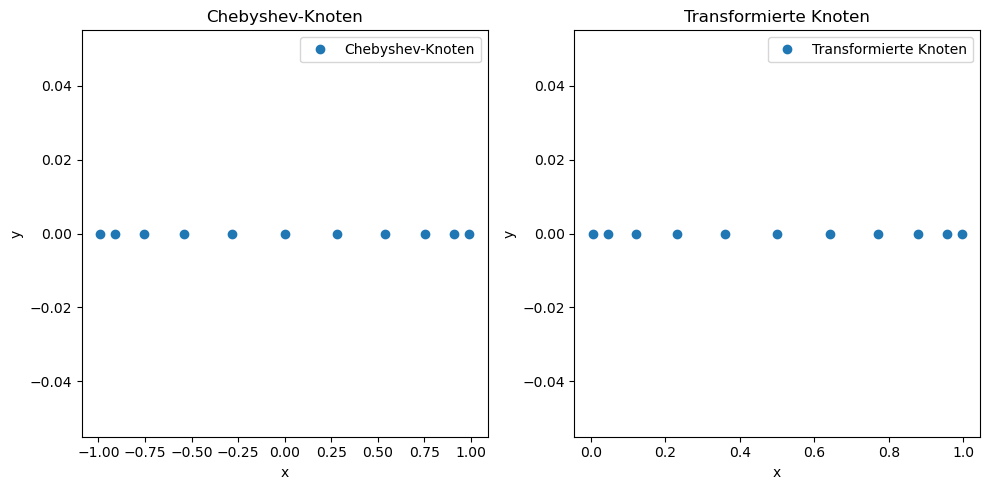

In [85]:
def plot_nodes(n):
    cheby_nodes = chebyshev_nodes(n)
    transformed_nodes = transform_nodes(cheby_nodes)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cheby_nodes, np.zeros_like(cheby_nodes), 'o', label='Chebyshev-Knoten')
    plt.title('Chebyshev-Knoten')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(transformed_nodes, np.zeros_like(transformed_nodes), 'o', label='Transformierte Knoten')
    plt.title('Transformierte Knoten')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

n = 10
plot_nodes(n)

Nun ist also die Approximation von $log(1+t)$ auf $[0,1]$ ausreichend

In [86]:
def f(x):
    return np.log(1+x)

Nun geht es darum die Koeffizienten Auszurechnen dazu haben wir nach Hinweis

$c_k = \frac{2}{n+1} \sum_{j=0}^n \log(1+ \frac{1+ cos(\frac{2j+1}{2n+1})}{2}\pi))\cos(k \frac{2j + 1}{2n+ 2}\pi)$

In [138]:
def compute_coefficients(n):
    coefficients = []
    for k in range(n+1):
        # nice
        c_k = (2/(n+1)) * sum(np.log(1+(1+np.cos((2*j+1)/(2*n+2)*np.pi))/2)*np.cos(k * (2*j+1)/(2*n+2) * np.pi)
                              for j in range(n+1)
                              )
        coefficients.append(c_k)
    #coefficients[0] *= 0.5
    return np.array(coefficients)

compute_coefficients(10)

# To not get confused here we need to multiply the first coefficient with 0.5
# then its the same solution as given in the paper on S.146 mitte



array([ 7.52905626e-01,  3.43145751e-01, -2.94372515e-02,  3.36708926e-03,
       -4.33275889e-04,  5.94707120e-05, -8.50296747e-06,  1.25046692e-06,
       -1.87725259e-07,  2.86130747e-08, -4.31250635e-09])

In the next and also last step we need to compute the polynomial, as a reminder we need to multiply $c_0$ with 0.5

Basically use Clenshaw (Satz 3.47)

Man hat $p(x)$ ein Polynom vom Grad $n$ und $c_0 ... c_n$ die Koeffizienten welche wir bereits oben berechnet haben.

Nun gilt

$p(x) = 0.5 * c_0 + c_1T_1(x) + c_2T_2(x) ...$

Man definiert $d_{n+2} = d_{n+1} = 0$ und 

$d_j = c_k + 2xd_{k+1}-d_{k+2}$ mit $k = n,n-1,0$



In [139]:
def clenshaw_algorithm(c,x,n):
    n = n+1

    d = np.zeros(n)
    d[n-1] = 0
    d[n-2] = 0
    for k in range(n-3,-1,-1):
        d[k] = c[k]+2*x*d[k+1]-d[k+2]
    return 0.5 * (d[0]-d[2])

Nun approximieren wir also den Logarithmus wie im Skript beschrieben

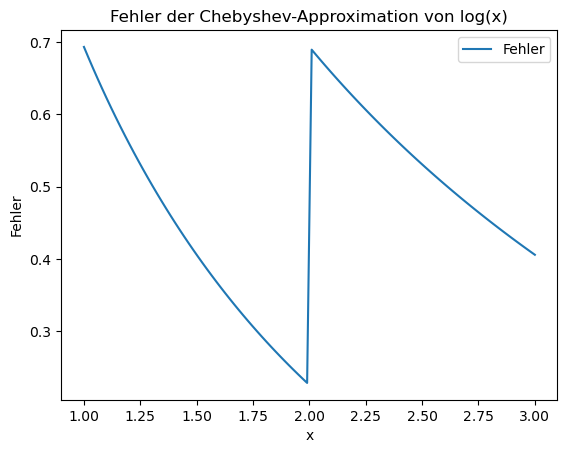

In [ ]:
def log_approx(x,coefficients,n):
    if x <=0:
        raise ValueError("x must be greater than zero")
    
    N = 0
    # Das entspricht also der Reduktion
    # Immer wann x > 2 teilen wir und addieren einmal zu N
    # Immer wann x < 1 ist multiplizieren wir mit 2 um in [1,2] zu landen und subtrahieren -1
    #
    while x > 2:
        x /= 2
        N += 1
    while x < 1:
        x *= 2
        N -= 1
    t = x-1
    log_1_t = clenshaw_algorithm(coefficients,x,n)
    return log_1_t + N*np.log(2)

n = 9
c = compute_coefficients(n)

x_vals = np.linspace(1,3, 100)
log_vals = np.log(x_vals)
clenshaw_values = np.array([log_approx(x, c, n) for x in x_vals])

error = np.abs(clenshaw_values - log_vals)

plt.plot(x_vals, error, label='Fehler')
plt.xlabel('x')
plt.ylabel('Fehler')
plt.title('Fehler der Chebyshev-Approximation von log(x)')
plt.legend()
plt.show()


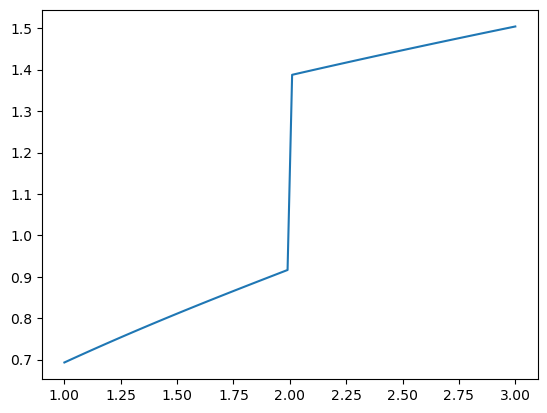

In [145]:
# plotte mal den Log schauen wie das aussieht

plt.plot(x_vals,clenshaw_values)
plt.show()